# Introduction

Tiem series forecasting using Recurrent Neural Networks (RNNs).

It is divided in two pars:
- Forecast a univariate time series
- Forecast a multivariate time series

### Set out 

In [30]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

'''Matplotlib is a Python 2D plotting library which produces 
publication quality figures in a variety of hardcopy formats 
and interactive environments across platforms. '''
import matplotlib as mpl
import matplotlib.pyplot as plt

'''NumPy is the fundamental package for scientific computing with Python. 
It contains among other things:
- a powerful N-dimensional array object
- sophisticated (broadcasting) functions
- tools for integrating C/C++ and Fortran code
- useful linear algebra, Fourier transform, and random number capabilitie'''
import numpy as np

import os

In [31]:
'''pandas is an open source, BSD-licensed library providing high-performance, 
easy-to-use data structures and data analysis tools for the Python 
programming language.'''
import pandas as pd 

In [32]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

The dataset used is a wheather time series that can be found here https://www.bgc-jena.mpg.de/wetter/

The dataset contains 14 different features such as air temperature, atmospheric
pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, it will be analyzed only the data collected between
 2009 and 2016. 

In [33]:
zip_path = tf.keras.utils.get_file(
    origin = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname = 'jena_climate_2009_2016.csv.zip',
    extract = True
)

'''used to split the path name into a pair root and ext. Here, ext stands 
for extension and has the extension portion of the specified path while 
root is everything except ext part.'''
csv_path, _ = os.path.splitext(zip_path)

In [34]:
df = pd.read_csv(csv_path)

In [35]:
#glance at the data
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


We can analyse the data and say:
- 6 observations per hour
- 144 observations per day

Given a specific time, let's predict the temperature 6 hours in the future. In order to make this prediction I choose 7 days of observations. Thus, I will create a window containing the last 1008 observations to train the mode. 

In the following code:
- history_size: it is the size of the past window of information
- target_size: it is how far in the future does the mode need to learn to predict 

In [49]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []
    
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    
    for i in range(start_index, end_index):
        indices = range (i-history_size, i)
        
        #Reshape data from (history_size) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
        
    return np.array(data), np.array(labels)

In [37]:
TRAIN_SPLIT = 300000
tf.random.set_seed(13)

### Part 1 - Forecast a univariate time series

Firstly, I will train a model using only a single feature (temperature), and use it to male predictions for that value in the future

In [38]:
#Extract the temperature from the dataset
uni_data = df['T (degC)']
uni_data.head()

0   -8.02
1   -8.41
2   -8.51
3   -8.31
4   -8.27
Name: T (degC), dtype: float64

In [39]:
#set the date and time to be the index
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000220E0AFDDA0>],
      dtype=object)

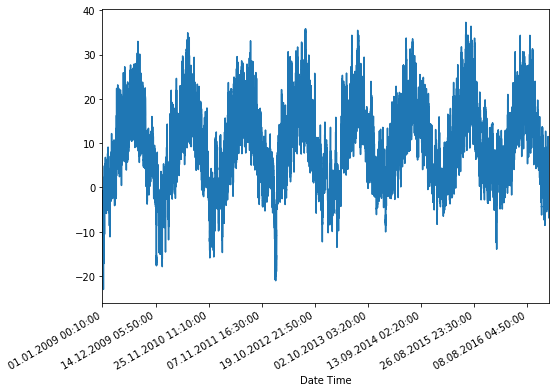

In [40]:
#let's observe this data across time
uni_data.plot(subplots=True)

In [41]:
#select only the values
uni_data = uni_data.values

In [42]:
uni_data

array([-8.02, -8.41, -8.51, ..., -3.16, -4.23, -4.82])

It is imporant now to normalize features before training a neuronal net. A common way to do so is by substracting the mean and dividing by the standard deviation of each feature

In [43]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [44]:
#Normalization
uni_data = (uni_data - uni_train_mean)/uni_train_std

Let's create the data for the univariate model. In this part, the model will be given the last 20 recorded temperature observations, and needs to learn to predict the temperature at the next time step.

In [45]:
univariate_past_history = 20
univariate_future_target = 0

In [50]:
x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)


In [51]:
#what the univariate_data function returns
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


The data has been created, let's take a look at a single example

In [52]:
def create_time_steps(length):
    time_steps = []
    for i in range(-length, 0, 1):
        time_steps.append(i)
    return time_steps

In [57]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Factor', 'Model Prediction']
    marker = ['.-', 'rx','go']
    
    time_steps = create_time_steps(plot_data[0].shape[0])
    
    if delta:
        future = delta
    else:
        future = 0
        
    plt.title(title)
    
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label = labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\Alex\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

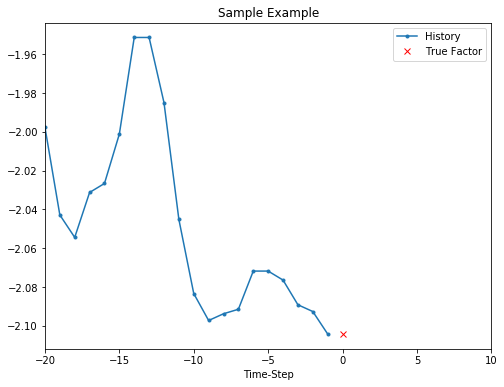

In [58]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

#### Baseline
Before to train the model, let's first set a simple baseline. Given an input point, the baseline method looks at all the history and predicts the next point to be the averge of the last 20 observations

In [73]:
def baseline(history):
    return np.mean(history)

<module 'matplotlib.pyplot' from 'C:\\Users\\Alex\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

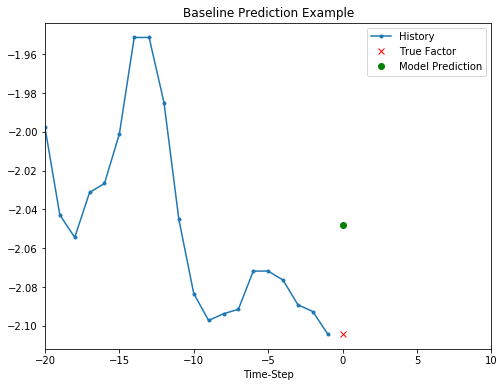

In [74]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0, 'Baseline Prediction Example')

Let's beat this baseline using a recurrent neuronal net.

#### Baseline

A Recurrent Neurla Network (RNN) is a type of nerual network well-suited to time series data. RNNs process a time series step-by step, mantatining an internal state summarizing the information thaey have seen so far.
In this project it will be used a specialized RNN layer called Long Short Term Memory.

In [75]:
# Let's shuffle, batch, and cache the datase.

BATCH_SIZE = 256
BUFFER_SIZE = 10000

# Creates a Dataset whose elements are slices of the given tensors
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()


How data are rappresented after the batch

![title](time_series.png)

In [76]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')


Let's make a simple prediction, to check the output of the model

In [77]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)


(256, 1)


I train the model now. Due to the large size of the dataset, in the interest of saving time, each epoch will only run for 200 steps, instead of the complete trainig data as normally done

In [80]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                    steps_per_epoch = EVALUATION_INTERVAL,
                    validation_data = val_univariate, validation_steps = 50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 10s 49ms/step - loss: 0.5244 - val_loss: 0.1434
Epoch 2/10
200/200 [==============================] - 4s 22ms/step - loss: 0.1405 - val_loss: 0.0417
Epoch 3/10
200/200 [==============================] - 5s 23ms/step - loss: 0.0561 - val_loss: 0.0280
Epoch 4/10
200/200 [==============================] - 4s 21ms/step - loss: 0.0447 - val_loss: 0.0247
Epoch 5/10
200/200 [==============================] - 4s 21ms/step - loss: 0.0294 - val_loss: 0.0224
Epoch 6/10
200/200 [==============================] - 5s 23ms/step - loss: 0.0309 - val_loss: 0.0216
Epoch 7/10
200/200 [==============================] - 4s 21ms/step - loss: 0.0283 - val_loss: 0.0202
Epoch 8/10
200/200 [==============================] - 4s 21ms/step - loss: 0.0266 - val_loss: 0.0193
Epoch 9/10
200/200 [==============================] - 4s 21ms/step - loss: 0.0256 - val_loss: 0.0185
Epoch 10/10
200/200 [==========================

##### Prediction using the simple LSTM model

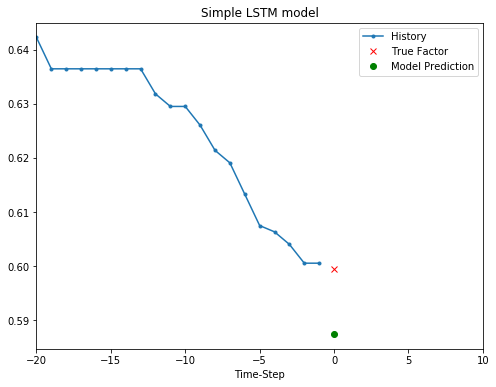

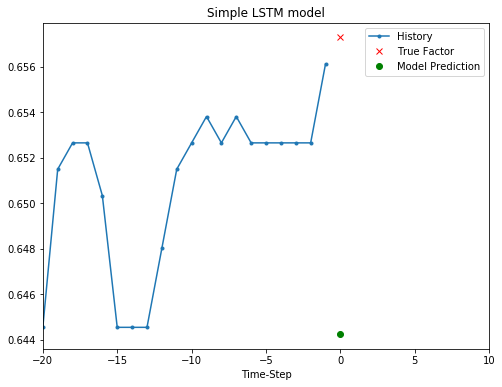

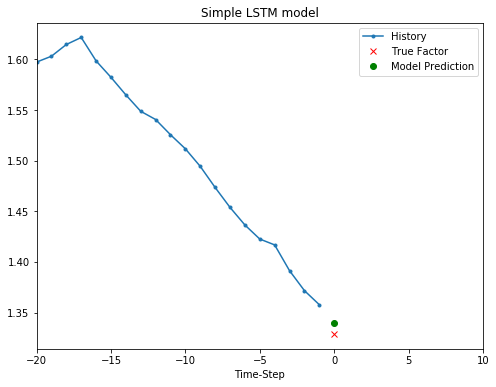

In [83]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    
    plot.show()